In [162]:
import pymatching
import sinter
import stim
from typing import *
import numpy as np
import matplotlib.pyplot as plt


def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    num_detectors = circuit.num_detectors
    num_observables = circuit.num_observables

    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Extract decoder configuration data from the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)

    # Run the decoder.
    predictions = sinter.predict_observables(
        dem=detector_error_model,
        dets=detection_events,
        decoder='pymatching',
    )

    # Count the mistakes.
    num_errors = 0
    for actual_flip, predicted_flip in zip(observable_flips, predictions):
        if not np.array_equal(actual_flip, predicted_flip):
            num_errors += 1
    return num_errors


def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

#print(line_intersection((A, B), (C, D)))


The two cells below produce a graphs to show how the probability of success changes as the error probability increases for the distance 2 repetition code and the distance 3 surface code.

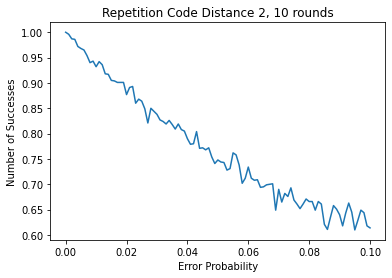

In [163]:
#This code generates a plot of the probability of success versus the error probability for
#a repetition code with a fixed distance and number of rounds.


distance = 2
rounds = 10
num_shots = 1000
success_rate = []

error_probs = np.arange(0, 0.101, 0.001)

for p in error_probs:
    circuit = stim.Circuit.generated("repetition_code:memory", rounds=rounds, distance=distance, before_round_data_depolarization=p)
    num_logical_errors = count_logical_errors(circuit, num_shots)
    num_successes = num_shots - num_logical_errors
    success_rate.append(num_successes/float(num_shots))

plt.plot(error_probs, success_rate)
plt.xlabel('Error Probability')
plt.ylabel('Number of Successes')
plt.title(f'Repetition Code Distance {distance}, {rounds} rounds')
plt.show()

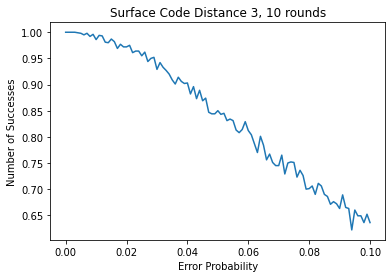

In [164]:
#This code generates a plot of the probability of success versus the error probability for
#a surface code with a fixed distance and number of rounds.

distance = 3
rounds = 10
num_shots = 1000
success_rate = []

error_probs = np.arange(0, 0.101, 0.001)

for p in error_probs:
    circuit = stim.Circuit.generated("surface_code:rotated_memory_z", rounds=rounds, distance=distance, before_round_data_depolarization=p)
    num_logical_errors = count_logical_errors(circuit, num_shots)
    num_successes = num_shots - num_logical_errors
    success_rate.append(num_successes/float(num_shots))

plt.plot(error_probs, success_rate)
plt.xlabel('Error Probability')
plt.ylabel('Number of Successes')
plt.title(f'Surface Code Distance {distance}, {rounds} rounds')
plt.show()

The cells below plot the probability of success against increasing number of rounds with a fixed probability for the distance 3 surface code and the distance 2 repetition code.

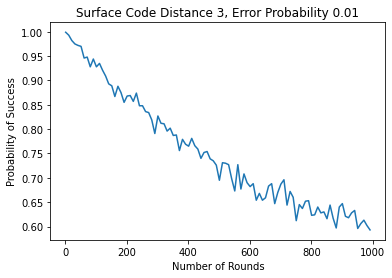

In [165]:
import matplotlib.pyplot as plt

#This code generates a plot of the probability of success versus 
#the number of rounds for a surface code with a fixed distance and error probability.

distance = 3
num_shots = 1000
success_rate = []

rounds_range = range(1, 1001, 10)

error_prob = 0.01

for r in rounds_range:
    circuit = stim.Circuit.generated("surface_code:rotated_memory_z", rounds=r, distance=distance, before_round_data_depolarization=error_prob)
    num_logical_errors = count_logical_errors(circuit, num_shots)
    num_successes = num_shots - num_logical_errors
    success_rate.append(num_successes/float(num_shots))

plt.plot(rounds_range, success_rate)
plt.xlabel('Number of Rounds')
plt.ylabel('Probability of Success')
plt.title(f'Surface Code Distance {distance}, Error Probability {error_prob}')
plt.show()

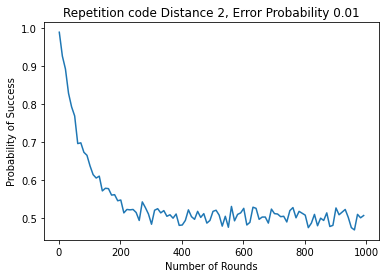

In [166]:
import matplotlib.pyplot as plt

#This code generates a plot of the probability of success versus
#the number of rounds for a surface code with a fixed distance and error probability.

distance = 2
num_shots = 1000
success_rate = []

rounds_range = range(1, 1001, 10)


error_prob = 0.01

for r in rounds_range:
    circuit = stim.Circuit.generated("repetition_code:memory", rounds=r, distance=distance, before_round_data_depolarization=error_prob)
    num_logical_errors = count_logical_errors(circuit, num_shots)
    num_successes = num_shots - num_logical_errors
    success_rate.append(num_successes/float(num_shots))

plt.plot(rounds_range, success_rate)
plt.xlabel('Number of Rounds')
plt.ylabel('Probability of Success')
plt.title(f'Repetition code Distance {distance}, Error Probability {error_prob}')
plt.show()


## Calculating the threshold 

Intersection at 0.40473383045579353


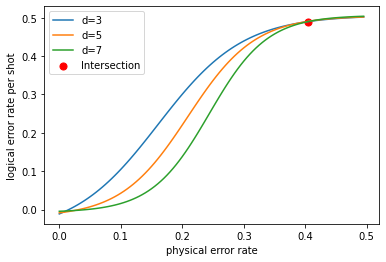

In [169]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root
import numpy as np
import stim


def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

error_probs = np.arange(0,0.5,0.005)

popts = []

num_shots = 10_000
for d in [3, 5, 7]:
    xs = []
    ys = []
    for noise in error_probs:
        circuit = stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise)
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        x = noise
        y = num_errors_sampled / num_shots
        xs.append(x)
        ys.append(y)
        
    p0 = [max(ys), np.median(xs),1,min(ys)] # this is an mandatory initial guess
    
    popt, pcov = curve_fit(sigmoid, xs, ys,p0, method='dogbox')
    
    popts.append(popt)
        
    fit_y = sigmoid(xs, *popt)

    plt.plot(xs, fit_y ,'-', label="d=" + str(d))

    
def diff(x):
    # Calculate y for each sigmoid function
    results = sorted([sigmoid(x, *popts[i]) for i in range(len(popts))])
    # Diff the max and min y
    return results[-1] - results[0]

# Find the intersection point using root-finding
sol = root(diff, 0.3)

plt.scatter(sol.x[0], sigmoid(sol.x[0], *popts[0]), s=50, c='red', label='Intersection')
print(f'Intersection at {sol.x[0]}')

plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()


In [168]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root
import numpy as np
import stim


def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

error_probs = np.arange(0,0.5,0.005)

popts = []

num_shots = 10_000
for d in [3, 5, 7]:
    xs = []
    ys = []
    for noise in error_probs:
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise)
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        x = noise
        y = num_errors_sampled / num_shots
        xs.append(x)
        ys.append(y)
        
    p0 = [max(ys), np.median(xs),1,min(ys)] # this is an mandatory initial guess
    
    popt, pcov = curve_fit(sigmoid, xs, ys,p0, method='dogbox')
    
    popts.append(popt)
        
    fit_y = sigmoid(xs, *popt)

    plt.plot(xs, fit_y ,'-', label="d=" + str(d))

    
def diff(x):
    # Calculate y for each sigmoid function
    results = sorted([sigmoid(x, *popts[i]) for i in range(len(popts))])
    # Diff the max and min y
    return results[-1] - results[0]

# Find the intersection point using root-finding
sol = root(diff, 0.3)

plt.scatter(sol.x[0], sigmoid(sol.x[0], *popts[0]), s=50, c='red', label='Intersection')
print(f'Intersection at {sol.x[0]}')

plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.